### General Concept

1. Given a pdf file of a bank transaction with multiple pages, get png/jpg of each page.
2. With png/jpg, detect relevant texts (e.g. Tanggal, Keterangan, Mutasi)
3. Put detected text into a DataFrame to be converted into a CSV file that is seperated by semicolons ;

Current issue: 1st page is empty

Current solution: Explicitly define page number

### Import Dump

In [1]:
import cv2
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import pytesseract
import warnings


warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\paoma\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Scanning

First we convert the pdf into a png per page

In [2]:
pdf_name = "DANAMON_PERSONAL.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    name = pdf_name[:-4] + "-page-" + str(page.number) + ".png"
    pix.save(name)

Use an OCR (optical character recognition) model for reading text

In [3]:
# define tesseract OCT model 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

Read the images to be put into an Image object in cv2

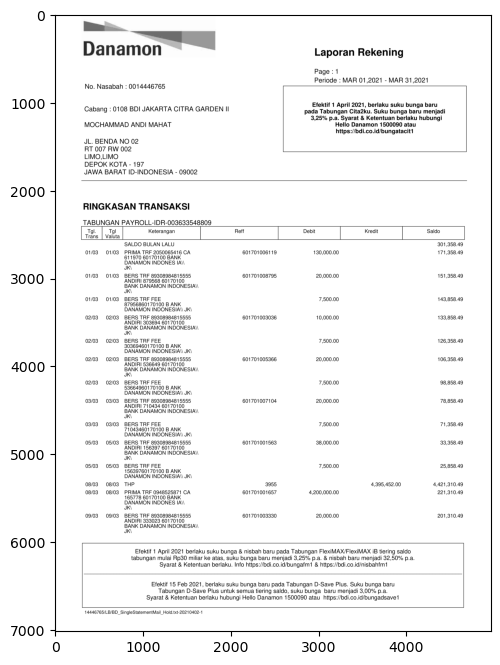

In [85]:
page_num = 0

page_name = pdf_name[:-4] + "-page-" + str(page_num) + ".png"

# read png
page = cv2.imread(page_name)

# to grayscale for model to easily process
page = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)

# show page image
plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

The important part of this file is below the row with "Tanggal, Keterangan, ...". So crop this part. Assume that the height ratio proportion of this bank statement to be stable. 

The height crop in this image should be around the 2050th pixel and the image is 7017 pixels high. So the ratio is 2050/7017 which is around 0.298. So crop at the 29.8% height of the image regardless of the image size.

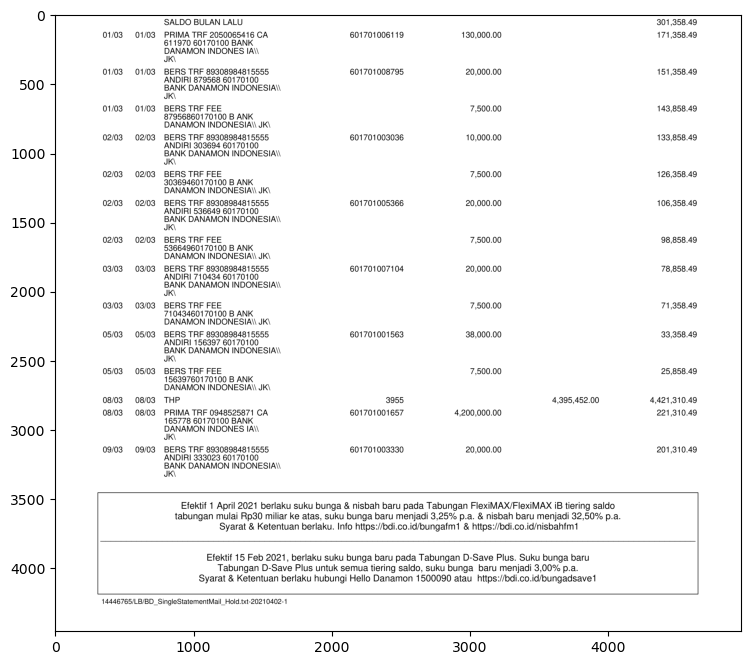

In [86]:
# get page height
page_height = page.shape[0]

# start of table is different per page
if page_num == 0:
    page = page[int(page_height * 0.365):, :]
else:
    page = page[int(page_height * 0.332):, :]

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

Create a threshold for creating pure monochrome image

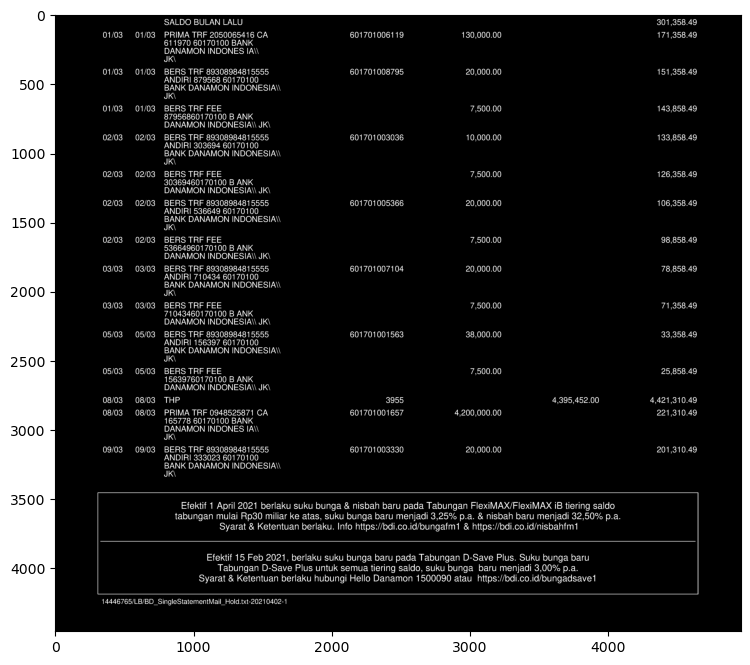

In [87]:
# define threshold
retval, thresh = cv2.threshold(page, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# show monochrome image
plt.figure(figsize=(30,8))
plt.imshow(thresh, cmap="gray")

Extract text using contours (rectangles around text) more simply for the model to detect characters.

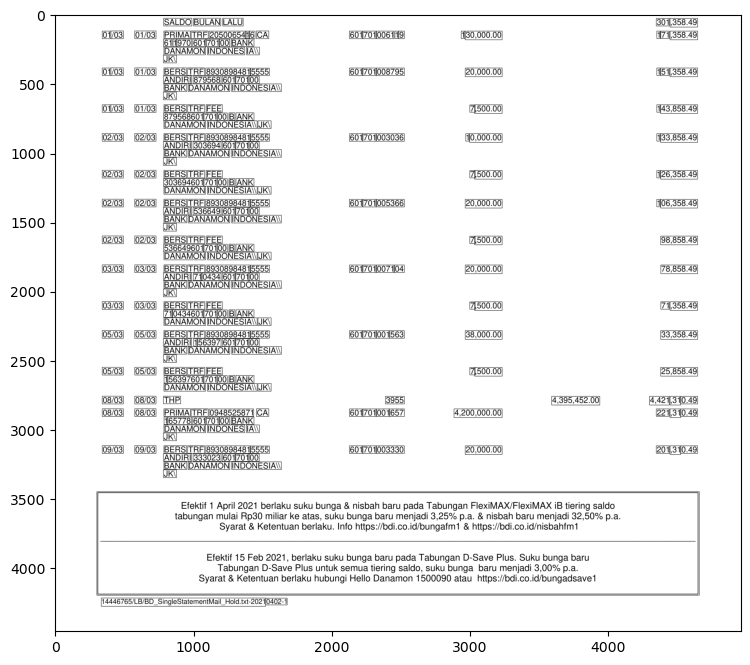

In [88]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# copy grayscale image from earlier to see the contours
page_copy = page.copy()

# make contour list to store text and its corresponding coordinates
cnt_list = []

# loop for each contour detected
for cnt in contours:

    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(page_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # crop text block by rectangle text block
    crop = page_copy[y:y+h, x:x+w]

    # use ocr model cropped image
    text = pytesseract.image_to_string(crop, config="--psm 13")

    # store coordinates and text
    cnt_list.append([x, y, text])

plt.figure(figsize=(30,8))
plt.imshow(page_copy, cmap="gray")

Sort text from left to right and from up to down

In [89]:
sorted_list = sorted(cnt_list, key = lambda x: x[0]) # sort by width first
sorted_list = sorted(sorted_list, key = lambda x: x[1]) # then height

sorted_list

[[785, 23, 'SALDO\n'],
 [1001, 23, 'BULAN\n'],
 [1212, 23, 'LALU\n'],
 [4346, 24, '301\n'],
 [4446, 24, '5358.49\n'],
 [404, 115, '/03\n'],
 [576, 115, '01/03\n'],
 [787, 115, 'PRIMA\n'],
 [984, 115, 'TRE\n'],
 [1456, 115, 'CA\n'],
 [341, 116, '01\n'],
 [1114, 116, '20500654\n'],
 [1378, 116, '1\n'],
 [1406, 116, '6\n'],
 [2128, 116, '601\n'],
 [2226, 116, '701\n'],
 [2323, 116, '0061\n'],
 [2457, 116, '1\n'],
 [2485, 116, '9\n'],
 [2936, 116, '1\n'],
 [2965, 116, '30,000.00\n'],
 [4350, 116, '1\n'],
 [4379, 116, '71\n'],
 [4446, 116, '5358.49\n'],
 [1273, 173, 'BANK\n'],
 [784, 174, '61\n'],
 [853, 174, '1\n'],
 [881, 174, '970\n'],
 [995, 174, '601\n'],
 [1093, 174, '701\n'],
 [1189, 174, '(ore)\n'],
 [787, 232, 'DANAMON\n'],
 [1102, 232, 'INDONES\n'],
 [1384, 232, 'IA\\\\\n'],
 [783, 290, 'JK\\\n'],
 [404, 382, '/03\n'],
 [576, 382, '01/03\n'],
 [787, 382, 'BERS\n'],
 [958, 382, 'TRE\n'],
 [341, 383, '01\n'],
 [1089, 383, '8930898481\n'],
 [2128, 383, '601\n'],
 [2226, 383, '701\n']

Make into DataFrame for 2D array manipulation to make it cleaner

In [79]:
# create dataframe
df = pd.DataFrame(sorted_list)
df.columns = ["x", "y", "Text"]

# omit trivial texts
df = df.drop(df[(df.Text == "")].index)

# Remove the \n in text
df["Text"] = df["Text"].str.replace("\n", "")
df = df.drop(df[(df.Text == "|") | (df.Text == "| |")].index)

df.head(20)

,x,y,Text
0,785,23,SALDO
1,1001,23,BULAN
2,1212,23,LALU
3,4346,24,301
4,4446,24,5358.49
5,404,115,/03
6,576,115,01/03
7,787,115,PRIMA
8,984,115,TRE
9,1456,115,CA


Each perceieved row in the image is seen to have a range of 2-5 pixels in its y (e.g. 43, 44, 45) by the model but it is important to make it so that it is in the same y that the paper is actually trying to tell

So replace a row's y point (defined as the top left of the row or contour) and everything that is near that y point (y+5) to be y

(To be optimized with df functions; or not? the runtime is 0s)

In [83]:
r = 0

for i in range(df.shape[0]):
    if i == 0:
        r = df["y"].iloc[0]

    y = df["y"].iloc[i]

    if y <= r+5:
        df["y"].iloc[i] = r
    else:
        r = y

# sort again left to right, top to bottom
df = df.sort_values(by=["y", "x"])

# delete saldo awal
if df["Text"].iloc[0].strip() == "SALDO":
    saldo_y = df["y"].iloc[0]
    df = df.drop(df[df.y == saldo_y].index)


df.head(20)

C:\Users\paoma\AppData\Local\Temp\ipykernel_22668\1937316669.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipykernel_22668\1937316669.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipykernel_22668\1937316669.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y"].iloc[i] = r
C:\Users\paoma\AppData\Local\Temp\ipy

,x,y,Text
0,341,115,01
1,404,115,/03
2,576,115,01/03
3,787,115,PRIMA
4,984,115,TRE
5,1114,115,20500654
6,1378,115,1
7,1406,115,6
8,1456,115,CA
9,2128,115,601


A row in the transaction is defined by each date's position. Similarly in the desired CSV, the same row shall have all of its elements with it. 

The date's x is always the most left (+/-5) so get the smallest x and split the dataset based on when each date is detected per row.

It is also desirable to make every element have its x known to detect which column it is in

Create a new DataFrame where columns store each column in the page (Tanggal, Keterangan, CBG, Mutasi, Saldo) and put each transaction row into one row. Keterangan will have multiple string elements concatenated

In [58]:
t = pd.DataFrame(columns=["Tgl Trans", "Tgl Valuta", "Keterangan", "Reff", "Debit", "Kredit", "Saldo"])

Find each left x coordinate of each column. First do a manual search of each x coordinate by plotting vertical lines in the page

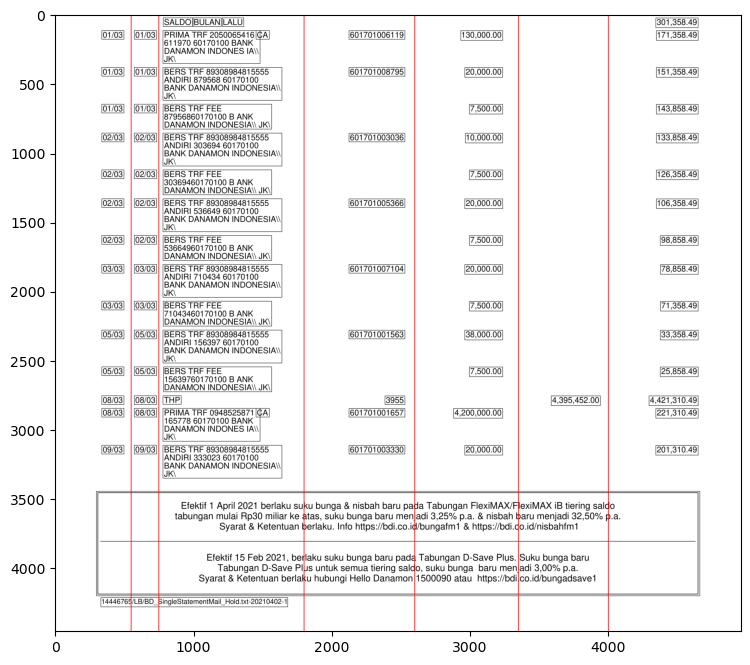

In [32]:
page_lines = page_copy.copy()
page_lines = cv2.cvtColor(page_lines, cv2.COLOR_GRAY2BGR)

line_xs = [550, 750, 1800, 2600, 3350, 4000]

for x in line_xs:
    cv2.line(page_lines, (x, 0), (x, page.shape[0]), (255, 0, 0), 4, cv2.LINE_AA)

plt.figure(figsize=(30, 8))
plt.imshow(page_lines)

Therefore for each column, its x coordinates are:
- Tgl Trans: x < 550
- Tgl Valuta: 550 < x < 750
- Keterangan: 750 < x < 1800
- Reff: 1800 < x < 2600
- Debit: 2600 < x < 3350
- Kredit: 3350 < x < 4000
- Saldo: 4000 < x

In [81]:
tt="";tv="";keterangan="";reff="";debit="";kredit="";saldo=""
tts=[];tvs=[];keterangans=[];reffs=[];debits=[];kredits=[];saldos=[]

# prevents summary at the end of pdf to be added
# exit = 0 # if SALDO and AWAL is detected in columns keterangan1 and keterangan2 correspondingly, append arrays and break

df = df._append({"x": 500, "y": 0, "Text": "a"}, ignore_index=True)

for i in range(df.shape[0]):
    x = df["x"].iloc[i]
    text = df["Text"].iloc[i]
    
    if x < 550:
        if tv != "":
            tts.append(tt)
            tvs.append(tv)
            keterangans.append(keterangan)
            reffs.append(reff)
            debits.append(debit)
            kredits.append(kredit)
            saldos.append(saldo)

            tt="";tv="";keterangan="";reff="";debit="";kredit="";saldo=""
        
        tt += text
    elif 550 < x < 750:
        tv += text + " "
    elif 750 < x < 1800:
        if text.strip() == "TOTAL":
            tts.append(tt)
            tvs.append(tv)
            keterangans.append(keterangan)
            reffs.append(reff)
            debits.append(debit)
            kredits.append(kredit)
            saldos.append(saldo)

            break
        else:
            keterangan += text + " "
    elif 1800 < x < 2600:
        reff += text
    elif 2600 < x < 3350:
        debit += text
    elif 3350 < x < 4000:
        kredit += text
    elif 4000 < x:
        saldo += text

t = pd.DataFrame({
            "Tgl Trans": tts,
            "Tgl Valuta": tvs,
            "Keterangan": keterangans,
            "Reff": reffs,
            "Debit": debits,
            "Kredit": kredits,
            "Saldo": saldos
        })

t = t[t["Tgl Trans"].str.contains("a") == False] # delete
t = t[(t["Tgl Trans"] == "") == False]


t

,Tgl Trans,Tgl Valuta,Keterangan,Reff,Debit,Kredit,Saldo
0,01/03,01/03,PRIMA TRE 20500654 1 6 CA 61 1 970 601 701 (or...,601701006119,"130,000.00",,1715358.49
1,01/03,01/03,BERS TRE 8930898481 5555 ANDIRI 879568 601 701...,601701008795,"20,000.00",,1515358.49
2,01/03,01/03,BERS TRE FEE 879568601 701 (re) B ANK DANAMON ...,,71500.00,,"143,858.49"
3,02/03,02/03,BERS TRE 8930898481 5555 ANDIRI 303694 601 701...,601701003036,"10,000.00",,"133,858.49"
4,02/03,02/03,BERS TRE FEE 303694601 701 (re) B ANK DANAMON ...,,71500.00,,"126,358.49"
5,02/03,02/03,BERS TRE 8930898481 5555 ANDIRI 536649 601 701...,601701005366,"20,000.00",,"106,358.49"
6,02/03,02/03,BERS TRE FEE 536649601 701 (re) B ANK DANAMON ...,,71500.00,,"98,858.49"
7,03/03,03/03,BERS TRE 8930898481 5555 ANDIRI 7 1 0434 601 7...,601701007104,"20,000.00",,"78,858.49"
8,03/03,03/03,BERS TRE FEE 7 1 0434601 701 (re) B ANK DANAMO...,,71500.00,,715358.49
9,05/03,05/03,BERS TRE 8930898481 5555 ANDIRI 1 56397 601 70...,601701001563,"38,000.00",,"33,358.49"


String postprocessing so the csv looks neater

In [62]:
# remove every element's last character (which is some unnecessary space)
t["Keterangan"] = t["Keterangan"].str[:-1]

In [67]:
# no space in dates amnd values
for column in t.columns:
    if column != "Keterangan":
        t[column] = t[column].str.replace(" ", "")

# emphasize perak in amount
for i in range(t.shape[0]):
    d = t["Debit"].iloc[i]
    k = t["Kredit"].iloc[i]
    s = t["Saldo"].iloc[i]

    if d[-3:-2] != ".":
        t["Debit"].iloc[i] = d[:-2] + "." + d[-2:]

    if k[-3:-2] != ".":
        t["Kredit"].iloc[i] = k[:-2] + "." + k[-2:]

    if s[-3:-2] != ".":
        t["Saldo"].iloc[i] = s[:-2] + "." + s[-2:]

t

,Tgl Trans,Tgl Valuta,Keterangan,Reff,Debit,Kredit,Saldo
0,09/03,09/03,BERS TRE FEE 333023601 701 (re) B ANK DANAMON ...,,71500.00,.,"193,810.49"
1,09/03,09/03,PRIMA 730 S11 G9972ZX BANK CENTRA L ASIA\\DEPO...,S11G9972X730,"150,000.00",.,"43,810.49"
2,09/03,09/03,PRIMA W/D FEE '730S1 G9972ZX BAN K CENTRAL ASI...,,71500.00,.,"36,310.49"
3,110/03,10/03,GAJIANDULUAN.ID_FLP551 99 29,0273633548809,.,"950,000.00","986,310.49"
4,11/03,11/03,PRIMA 1 28 S11 G997Z8 BANK CENTR AL ASIA\\DEPO...,S11G9972Z82128,"900,000.00",.,"86,310.49"
5,11/03,11/03,BERS TRE 8930898481 5555 ANDIRI 1 50874 601 70...,601701001508,"50,000.00",.,"36,310.49"
6,11/03,11/03,BERS TRE FEE 1 50874601 701 (re) B ANK DANAMON...,,71500.00,.,"28,810.49"
7,15/03,15/03,MONTHL YY ADMINISTRATION FE,,"5,000.00",.,"23,810.49"
8,15/03,15/03,PENAL TY BELOW MIN BA,,"5,000.00",.,"18,810.49"
9,31/03,31/03,CREDIT INTEREST CAPITALISE,,.,20.27,"18,830!.76"


Finally put the dataframe into csv

In [61]:
final = t.copy()

final.to_csv("transactions.csv", index=False, sep=";")